#Library

In [ ]:
pip install gymnasium[atari]==0.29.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 57.7 MB/s eta 0:00:00
  Attempting uninstall: gymnasium
    Found existing installation: gymnasium 1.0.0
    Uninstalling gymnasium-1.0.0:
      Successfully uninstalled gymnasium-1.0.0
  Attempting uninstall: ale-py
    Found existing installation: ale-py 0.10.1
    Uninstalling ale-py-0.10.1:
      Successfully uninstalled ale-py-0.10.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.1.2 requires ale-py>=0.10.1, but you have ale-py 0.8.1 which is incompatible.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.1 which is incompatible.


In [ ]:
pip install gymnasium[accept-rom-license]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 7.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.6.1-py3-none-any.whl size=446667 sha256=f9498c7cce5933c0237d035809b578bf5c806ade48ecf61c944b2aab003fa9b3
  Stored in directory: /root/.cache/pip/wheels/bc/fc/c6/8aa657c0d2089982f2dabd110efc68c61eb49831fdb7397351
Successfully built AutoROM.accept-rom-license


In [ ]:
pip install gymnasium[atari] ale-py

#Implémentation de DQN et DDQN avec CNN sur les jeux d'atari
Lister tous les environnements disponibles

In [ ]:
import gymnasium as gym
envs = gym.envs.registry
for env_spec in sorted(envs):
    print(env_spec)


Code complet pour lancer le script de DDQN/DQN avec CNN et visualiser les performances sur chaque étape du jeu
Tests à faire:


1.   Zaxxon
2.   Alien
3.Space Invaders



In [ ]:
import gymnasium as gym
import math
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import namedtuple, deque
from itertools import count
import matplotlib.pyplot as plt
from itertools import zip_longest

# Définir le device (GPU si disponible, sinon CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transition pour Replay Memory
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

# Classe Replay Memory
class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# Réseau DQN
class DQN(nn.Module):
    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5, stride=2)

        # Calcul de la taille après les convolutions
        def conv2d_size_out(size, kernel_size=5, stride=2):
            return (size - (kernel_size - 1) - 1) // stride + 1

        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 64
        self.head = nn.Linear(linear_input_size, outputs)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        return self.head(x.view(x.size(0), -1))

# Pré-traitement des observations
def preprocess_observation(observation):
    import cv2
    resized = cv2.resize(observation, (84, 84))
    normalized = resized / 255.0
    return torch.tensor(normalized, device=device, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)

# Stratégie epsilon-greedy pour sélectionner les actions
def select_action(state, policy_net, n_actions, steps_done, EPS_START, EPS_END, EPS_DECAY):
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

# Optimisation du modèle
def optimize_model(policy_net, target_net, memory, optimizer, BATCH_SIZE, GAMMA, use_ddqn):
    if len(memory) < BATCH_SIZE:
        return

    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        if use_ddqn:
            next_actions = policy_net(non_final_next_states).max(1).indices
            next_state_values[non_final_mask] = target_net(non_final_next_states).gather(1, next_actions.unsqueeze(1)).squeeze(1)
        else:
            next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values

    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

# Entraînement pour un épisode
def train_episode(env, policy_net, target_net, optimizer, memory, n_actions, steps_done, EPS_START, EPS_END, EPS_DECAY, BATCH_SIZE, GAMMA, TAU, use_ddqn):
    state, _ = env.reset()
    state = preprocess_observation(state)

    total_reward = 0
    q_values = []
    rewards=[]
    iteration=0
    for t in count():
        action = select_action(state, policy_net, n_actions, steps_done, EPS_START, EPS_END, EPS_DECAY)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated
        next_state = None if done else preprocess_observation(observation)

        memory.push(state, action, next_state, reward)
        state = next_state
        total_reward += reward.item()
        rewards.append(total_reward)
        iteration+=1

        if len(memory) >= BATCH_SIZE:
            optimize_model(policy_net, target_net, memory, optimizer, BATCH_SIZE, GAMMA, use_ddqn)

        with torch.no_grad():
            for target_param, policy_param in zip(target_net.parameters(), policy_net.parameters()):
                target_param.data.copy_(policy_param.data * TAU + target_param.data * (1.0 - TAU))

        with torch.no_grad():
            if state is not None:
                q_value = policy_net(state).max(1)[0].item()
                q_values.append(q_value)
        if done:
            break

    return total_reward,q_values,rewards


def pad_sequences(data, fill_value=np.nan):
    return np.array(list(zip_longest(*data, fillvalue=fill_value))).T



def plot_results(scores_dqn_runs, scores_ddqn_runs, q_values_dqn_run, q_values_ddqn_run):
    print("scores_dqn_runs",scores_dqn_runs)

    # Appliquer le padding aux Q-values
    q_values_dqn_run = pad_sequences(q_values_dqn_run)
    q_values_ddqn_run = pad_sequences(q_values_ddqn_run)
    scores_dqn_runs = pad_sequences(scores_dqn_runs)
    scores_ddqn_runs = pad_sequences(scores_ddqn_runs)
    #scores
    median_dqn = np.nanmedian(scores_dqn_runs, axis=0)
    lower_dqn = np.nanpercentile(scores_dqn_runs, 25, axis=0)
    upper_dqn = np.nanpercentile(scores_dqn_runs, 75, axis=0)

    median_ddqn = np.nanmedian(scores_ddqn_runs, axis=0)
    lower_ddqn = np.nanpercentile(scores_ddqn_runs, 25, axis=0)
    upper_ddqn = np.nanpercentile(scores_ddqn_runs, 75, axis=0)
    #q_values

    # Calculer les médianes en ignorant les NaN
    median_dqn_q = np.nanmedian(q_values_dqn_run, axis=0)
    lower_dqn_q = np.nanpercentile(q_values_dqn_run, 25, axis=0)
    upper_dqn_q = np.nanpercentile(q_values_dqn_run, 75, axis=0)

    median_ddqn_q = np.nanmedian(q_values_ddqn_run, axis=0)
    lower_ddqn_q = np.nanpercentile(q_values_ddqn_run, 25, axis=0)
    upper_ddqn_q = np.nanpercentile(q_values_ddqn_run, 75, axis=0)

    num_episodes_scores = min(len(scores_dqn_runs[0]),len(scores_ddqn_runs[0]))  #
    num_episodes_scores = min(len(scores_dqn_runs[0]),len(scores_ddqn_runs[0]))  #
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))  # 1 ligne, 2 colonnes

    # Premier graphe : Scores
    # Use the length of median_dqn for the x-axis of scores
    x_range_scores = range(1, min(len(median_dqn), len(median_ddqn)) + 1)
    axs[0].plot(x_range_scores, median_dqn[:len(x_range_scores)], label='DQN Median')
    axs[0].fill_between(x_range_scores, lower_dqn[:len(x_range_scores)], upper_dqn[:len(x_range_scores)], alpha=0.2)
    axs[0].plot(x_range_scores, median_ddqn[:len(x_range_scores)], label='DDQN Median')
    axs[0].fill_between(x_range_scores, lower_ddqn[:len(x_range_scores)], upper_ddqn[:len(x_range_scores)], alpha=0.2)
    # Titre et labels
    axs[0].set_title('Scores (Log Scale)')
    axs[0].set_xlabel('Training Steps (log scale)')
    axs[0].set_ylabel('Scores')
    #axs[0].set_yscale('log')

    # Appliquer l'échelle logarithmique sur l'axe x
    #axs[0].set_xscale('log')

    axs[0].legend()

    # Deuxième graphe : Q-values
    # Use the minimum length for the x-axis of Q-values
    x_range_q = range(min(len(median_dqn_q), len(median_ddqn_q)))
    axs[1].plot(x_range_q, median_dqn_q[:len(x_range_q)], label='DQN Median Q-value')
    axs[1].fill_between(x_range_q, lower_dqn_q[:len(x_range_q)], upper_dqn_q[:len(x_range_q)], alpha=0.2)
    axs[1].plot(x_range_q, median_ddqn_q[:len(x_range_q)], label='DDQN Median Q-value')
    axs[1].fill_between(x_range_q, lower_ddqn_q[:len(x_range_q)], upper_ddqn_q[:len(x_range_q)], alpha=0.2)
    axs[1].set_title('Q-values (log scale)')
    axs[1].set_xlabel('step training')
    axs[1].set_ylabel('Q-values(log scale)')
    axs[1].set_yscale('log')
    axs[1].legend()

    # Ajuster l'espacement
    plt.tight_layout()
    plt.show()

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Fix seed function
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

# Define Transition namedtuple
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

# Fonction principale d'entraînement
def train_and_plot(env_name, num_episodes, num_runs, EPS_START, EPS_END, EPS_DECAY, BATCH_SIZE, GAMMA, TAU):
    env = gym.make(env_name, render_mode="rgb_array")
    n_actions = env.action_space.n
    init_screen = env.reset()[0]
    _, _, screen_height, screen_width = preprocess_observation(init_screen).shape

    scores_dqn_runs, scores_ddqn_runs = [], []
    q_values_dqn_run, q_values_ddqn_run = [], []
    iteration_run=[]


    # Initialisation des réseaux DQN
    policy_net_dqn = DQN(screen_height, screen_width, n_actions).to(device)
    target_net_dqn = DQN(screen_height, screen_width, n_actions).to(device)
    target_net_dqn.load_state_dict(policy_net_dqn.state_dict())
    target_net_dqn.eval()
    optimizer_dqn = optim.AdamW(policy_net_dqn.parameters(), lr=1e-4, amsgrad=True)
    memory_dqn = ReplayMemory(10000)

    # Initialisation des réseaux DDQN
    policy_net_ddqn = DQN(screen_height, screen_width, n_actions).to(device)
    target_net_ddqn = DQN(screen_height, screen_width, n_actions).to(device)
    target_net_ddqn.load_state_dict(policy_net_ddqn.state_dict())
    target_net_ddqn.eval()
    optimizer_ddqn = optim.AdamW(policy_net_ddqn.parameters(), lr=1e-4, amsgrad=True)
    memory_ddqn = ReplayMemory(10000)

    scores_dqn, scores_ddqn = [], []
    q_values_dqn, q_values_ddqn = [], []
    iteration=[]

    for episode in range(num_episodes):
        print("Epoch de l'entrainement:",episode)
            # Entraînement DQN

        dqn_score, dqn_q_values ,rewards= train_episode(env, policy_net_dqn, target_net_dqn, optimizer_dqn, memory_dqn, n_actions,0, EPS_START, EPS_END, EPS_DECAY, BATCH_SIZE, GAMMA,TAU ,use_ddqn=False)
        scores_dqn.append(rewards)
        q_values_dqn.append(dqn_q_values)

        # Entraînement DDQN
        ddqn_score, ddqn_q_values,rewards_ddqn = train_episode(env, policy_net_ddqn, target_net_ddqn, optimizer_ddqn, memory_ddqn, n_actions, 0, EPS_START, EPS_END, EPS_DECAY, BATCH_SIZE, GAMMA,TAU, use_ddqn=True)
        scores_ddqn.append(rewards_ddqn)
        q_values_ddqn.append(ddqn_q_values)
        #print("q_values",q_values_ddqn)



    # Plotting
    plot_results(scores_dqn, scores_ddqn, q_values_dqn, q_values_ddqn)

# Lancer l'entraînement
train_and_plot(
    env_name="Zaxxon-v4",
    num_episodes=200,
    num_runs=3,
    EPS_START=0.9,
    EPS_END=0.1,
    EPS_DECAY=5000,
    BATCH_SIZE=128,
    GAMMA=0.99,
    TAU=0.001
)
#zaxonn _v5 : des bonnes resultats après 100 iter
#space invade : pas bien car les q_value se chevauche
#Alien: il ya un difference au debut cpour ça il faut , ca marche bien en terme de q_values autour de 100 iter juste jusqu'a 150 c bien
#wizard of word: lent :) mais un peu bien en terme de score
#asterix : pas bien du tous  Q_value de DDQN au dessus de celle de DQN
#Time pilote: lent un peu et pas bien les Q_values se chauvauchent autour des 10 premier iterations
#

Epoch de l'entrainement: 0
Epoch de l'entrainement: 1
Epoch de l'entrainement: 2
Epoch de l'entrainement: 3
Epoch de l'entrainement: 4
Epoch de l'entrainement: 5
Epoch de l'entrainement: 6
Epoch de l'entrainement: 7
Epoch de l'entrainement: 8
Epoch de l'entrainement: 9
Epoch de l'entrainement: 10
Epoch de l'entrainement: 11
Epoch de l'entrainement: 12
Epoch de l'entrainement: 13
Epoch de l'entrainement: 14
Epoch de l'entrainement: 15
Epoch de l'entrainement: 16
Epoch de l'entrainement: 17
Epoch de l'entrainement: 18
Epoch de l'entrainement: 19
Epoch de l'entrainement: 20
Epoch de l'entrainement: 21
Epoch de l'entrainement: 22
Epoch de l'entrainement: 23
Epoch de l'entrainement: 24
Epoch de l'entrainement: 25
Epoch de l'entrainement: 26
Epoch de l'entrainement: 27
Epoch de l'entrainement: 28
Epoch de l'entrainement: 29
Epoch de l'entrainement: 30
Epoch de l'entrainement: 31
Epoch de l'entrainement: 32
Epoch de l'entrainement: 33
Epoch de l'entrainement: 34
Epoch de l'entrainement: 35
Ep

code complet pour visualiser les performances scores et Q_value à la fin/en moyenne de chaque jeu

In [ ]:
import gymnasium as gym
import math
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import namedtuple, deque
from itertools import count
import matplotlib.pyplot as plt
from itertools import zip_longest

# Définir le device (GPU si disponible, sinon CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transition pour Replay Memory
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

# Classe Replay Memory
class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# Réseau DQN
class DQN(nn.Module):
    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5, stride=2)

        # Calcul de la taille après les convolutions
        def conv2d_size_out(size, kernel_size=5, stride=2):
            return (size - (kernel_size - 1) - 1) // stride + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 64
        self.head = nn.Linear(linear_input_size, outputs)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        return self.head(x.view(x.size(0), -1))

# Pré-traitement des observations
def preprocess_observation(observation):
    import cv2
    resized = cv2.resize(observation, (84, 84))
    normalized = resized / 255.0
    return torch.tensor(normalized, device=device, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)

# Stratégie epsilon-greedy pour sélectionner les actions
def select_action(state, policy_net, n_actions, steps_done, EPS_START, EPS_END, EPS_DECAY):
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

# Optimisation du modèle
def optimize_model(policy_net, target_net, memory, optimizer, BATCH_SIZE, GAMMA, use_ddqn):
    if len(memory) < BATCH_SIZE:
        return

    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        if use_ddqn:
            next_actions = policy_net(non_final_next_states).max(1).indices
            next_state_values[non_final_mask] = target_net(non_final_next_states).gather(1, next_actions.unsqueeze(1)).squeeze(1)
        else:
            next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values

    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

# Entraînement pour un épisode
def train_episode(env, policy_net, target_net, optimizer, memory, n_actions, steps_done, EPS_START, EPS_END, EPS_DECAY, BATCH_SIZE, GAMMA, TAU, use_ddqn):
    state, _ = env.reset()
    state = preprocess_observation(state)

    total_reward = 0
    q_values = []
    rewards=[]
    iteration=0
    for t in count():
        action = select_action(state, policy_net, n_actions, steps_done, EPS_START, EPS_END, EPS_DECAY)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated
        next_state = None if done else preprocess_observation(observation)

        memory.push(state, action, next_state, reward)
        state = next_state
        total_reward += reward.item()
        rewards.append(total_reward)
        iteration+=1

        if len(memory) >= BATCH_SIZE:
            optimize_model(policy_net, target_net, memory, optimizer, BATCH_SIZE, GAMMA, use_ddqn)

        with torch.no_grad():
            for target_param, policy_param in zip(target_net.parameters(), policy_net.parameters()):
                target_param.data.copy_(policy_param.data * TAU + target_param.data * (1.0 - TAU))
        # Track the Q-values for monitoring
        with torch.no_grad():
            if state is not None:
                q_value = policy_net(state).max(1)[0].item()
                q_values.append(q_value)
        if done:
            break

    return total_reward,q_values,rewards

# Convertir les listes irrégulières en tableau
def pad_sequences(data, fill_value=np.nan):
    return np.array(list(zip_longest(*data, fillvalue=fill_value))).T



def plot_results(scores_dqn_runs, scores_ddqn_runs, q_values_dqn_run, q_values_ddqn_run):
    print("scores_dqn_runs",scores_dqn_runs)

    # Appliquer le padding aux Q-values
    q_values_dqn_run = pad_sequences(q_values_dqn_run)
    q_values_ddqn_run = pad_sequences(q_values_ddqn_run)
    scores_dqn_runs = pad_sequences(scores_dqn_runs)
    scores_ddqn_runs = pad_sequences(scores_ddqn_runs)
    #scores
    median_dqn = np.nanmedian(scores_dqn_runs, axis=0)
    lower_dqn = np.nanpercentile(scores_dqn_runs, 25, axis=0)
    upper_dqn = np.nanpercentile(scores_dqn_runs, 75, axis=0)

    median_ddqn = np.nanmedian(scores_ddqn_runs, axis=0)
    lower_ddqn = np.nanpercentile(scores_ddqn_runs, 25, axis=0)
    upper_ddqn = np.nanpercentile(scores_ddqn_runs, 75, axis=0)
    #q_values

    # Calculer les médianes en ignorant les NaN
    median_dqn_q = np.nanmedian(q_values_dqn_run, axis=0)
    lower_dqn_q = np.nanpercentile(q_values_dqn_run, 25, axis=0)
    upper_dqn_q = np.nanpercentile(q_values_dqn_run, 75, axis=0)

    median_ddqn_q = np.nanmedian(q_values_ddqn_run, axis=0)
    lower_ddqn_q = np.nanpercentile(q_values_ddqn_run, 25, axis=0)
    upper_ddqn_q = np.nanpercentile(q_values_ddqn_run, 75, axis=0)

    num_episodes_scores = min(len(scores_dqn_runs[0]),len(scores_ddqn_runs[0]))  #
    num_episodes_scores = min(len(scores_dqn_runs[0]),len(scores_ddqn_runs[0]))  #
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))  # 1 ligne, 2 colonnes

    # Premier graphe : Scores
    # Use the length of median_dqn for the x-axis of scores
    x_range_scores = range(1, min(len(median_dqn), len(median_ddqn)) + 1)
    axs[0].plot(x_range_scores, median_dqn[:len(x_range_scores)], label='DQN Median')
    axs[0].fill_between(x_range_scores, lower_dqn[:len(x_range_scores)], upper_dqn[:len(x_range_scores)], alpha=0.2)
    axs[0].plot(x_range_scores, median_ddqn[:len(x_range_scores)], label='DDQN Median')
    axs[0].fill_between(x_range_scores, lower_ddqn[:len(x_range_scores)], upper_ddqn[:len(x_range_scores)], alpha=0.2)
    # Titre et labels
    axs[0].set_title('Scores (Log Scale)')
    axs[0].set_xlabel('Training Steps (log scale)')
    axs[0].set_ylabel('Scores')
    axs[0].set_yscale('log')

    # Appliquer l'échelle logarithmique sur l'axe x
    #axs[0].set_xscale('log')

    axs[0].legend()

    # Deuxième graphe : Q-values
    # Use the minimum length for the x-axis of Q-values
    x_range_q = range(min(len(median_dqn_q), len(median_ddqn_q)))
    axs[1].plot(x_range_q, median_dqn_q[:len(x_range_q)], label='DQN Median Q-value')
    axs[1].fill_between(x_range_q, lower_dqn_q[:len(x_range_q)], upper_dqn_q[:len(x_range_q)], alpha=0.2)
    axs[1].plot(x_range_q, median_ddqn_q[:len(x_range_q)], label='DDQN Median Q-value')
    axs[1].fill_between(x_range_q, lower_ddqn_q[:len(x_range_q)], upper_ddqn_q[:len(x_range_q)], alpha=0.2)
    axs[1].set_title('Q-values (log scale)')
    axs[1].set_xlabel('step training')
    axs[1].set_ylabel('Q-values(log scale)')
    axs[1].set_yscale('log')
    axs[1].legend()

    # Ajuster l'espacement
    plt.tight_layout()
    plt.show()

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Fix seed function
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

# Define Transition namedtuple
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

# Fonction principale d'entraînement
def train_and_plot(env_name, num_episodes, num_runs, EPS_START, EPS_END, EPS_DECAY, BATCH_SIZE, GAMMA, TAU):
    env = gym.make(env_name, render_mode="rgb_array")
    n_actions = env.action_space.n
    init_screen = env.reset()[0]
    _, _, screen_height, screen_width = preprocess_observation(init_screen).shape

    scores_dqn_runs, scores_ddqn_runs = [], []
    q_values_dqn_run, q_values_ddqn_run = [], []
    iteration_run=[]

    for run in range(num_runs):
        print(f"Run: {run+1}/{num_runs}")
        set_seed(run)
        # Initialisation des réseaux DQN
        policy_net_dqn = DQN(screen_height, screen_width, n_actions).to(device)
        target_net_dqn = DQN(screen_height, screen_width, n_actions).to(device)
        target_net_dqn.load_state_dict(policy_net_dqn.state_dict())
        target_net_dqn.eval()
        optimizer_dqn = optim.AdamW(policy_net_dqn.parameters(), lr=1e-4, amsgrad=True)
        memory_dqn = ReplayMemory(10000)

        # Initialisation des réseaux DDQN
        policy_net_ddqn = DQN(screen_height, screen_width, n_actions).to(device)
        target_net_ddqn = DQN(screen_height, screen_width, n_actions).to(device)
        target_net_ddqn.load_state_dict(policy_net_ddqn.state_dict())
        target_net_ddqn.eval()
        optimizer_ddqn = optim.AdamW(policy_net_ddqn.parameters(), lr=1e-4, amsgrad=True)
        memory_ddqn = ReplayMemory(10000)

        scores_dqn, scores_ddqn = [], []
        q_values_dqn, q_values_ddqn = [], []
        iteration=[]

        for episode in range(num_episodes):
            print("Epoch de l'entrainement:",episode)
            # Entraînement DQN

            dqn_score, dqn_q_values ,rewards= train_episode(env, policy_net_dqn, target_net_dqn, optimizer_dqn, memory_dqn, n_actions,0, EPS_START, EPS_END, EPS_DECAY, BATCH_SIZE, GAMMA,TAU ,use_ddqn=False)
            scores_dqn.append(np.sum(rewards))
            q_values_dqn.append(np.mean(dqn_q_values))

            # Entraînement DDQN
            ddqn_score, ddqn_q_values,rewards_ddqn = train_episode(env, policy_net_ddqn, target_net_ddqn, optimizer_ddqn, memory_ddqn, n_actions, 0, EPS_START, EPS_END, EPS_DECAY, BATCH_SIZE, GAMMA,TAU, use_ddqn=True)
            scores_ddqn.append(np.sum(rewards_ddqn))
            q_values_ddqn.append(np.mean(ddqn_q_values))
        #print("q_values",q_values_ddqn)

        scores_dqn_runs.append(scores_dqn)
        scores_ddqn_runs.append(scores_ddqn)
        q_values_dqn_run.append(q_values_dqn)
        q_values_ddqn_run.append(q_values_ddqn)
    print("q_runs",q_values_dqn_run)
    # Plotting
    plot_results(scores_dqn_runs, scores_ddqn_runs, q_values_dqn_run, q_values_ddqn_run)

# Lancer l'entraînement
train_and_plot(
    env_name="ALE/WizardOfWor-v5",
    num_episodes=100,
    num_runs=1,
    EPS_START=1.0,
    EPS_END=0.1,
    EPS_DECAY=5000,
    BATCH_SIZE=32,
    GAMMA=0.99,
    TAU=0.001
)


#Implémentation de DQN et de DDQN avec NN

In [ ]:
import gymnasium as gym
import math
import random
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from itertools import zip_longest

In [ ]:

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Fix seed function
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

# Define Transition namedtuple
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

In [ ]:

# Define ReplayMemory class
class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [ ]:

# Define the DQN class
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [ ]:
# Select action based on epsilon-greedy policy
steps_done = 0
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 5000

In [ ]:
# Optimization functions (DQN and DDQN)
BATCH_SIZE = 128
GAMMA = 0.99

In [ ]:
# Helper function to select action
def select_action(state, policy_net, n_actions,steps_done,EPS_START,EPS_END,EPS_DECAY):
    #global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)


In [ ]:
def optimize_model(policy_net, target_net, memory, optimizer, BATCH_SIZE, GAMMA, use_ddqn):
    if len(memory) < BATCH_SIZE:
        return

    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Q-values actuelles
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Calcul des Q-values cibles
    next_state_values = torch.zeros(BATCH_SIZE, device=device)

    with torch.no_grad():
        if use_ddqn:
            # DDQN : sélection de l'action avec le réseau principal, évaluation avec le réseau cible
            next_actions = policy_net(non_final_next_states).max(1).indices
            next_state_values[non_final_mask] = target_net(non_final_next_states).gather(1, next_actions.unsqueeze(1)).squeeze(1)
        else:
            # DQN : sélection et évaluation avec le réseau cible
            next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values

    # Calcul des valeurs cibles
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Calcul de la perte
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimisation
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()


In [ ]:
# Convertir les listes irrégulières en un tableau avec des NaN pour les positions manquantes
def pad_sequences(data, fill_value=np.nan):
    return np.array(list(zip_longest(*data, fillvalue=fill_value))).T

In [ ]:
# Function to plot the results
def plot_results(scores_dqn_runs, scores_ddqn_runs, q_values_dqn_run, q_values_ddqn_run, num_episodes):
    # Appliquer le padding aux Q-values
    q_values_dqn_run = pad_sequences(q_values_dqn_run)
    q_values_ddqn_run = pad_sequences(q_values_ddqn_run)
    #scores
    median_dqn = np.median(scores_dqn_runs, axis=0)
    lower_dqn = np.percentile(scores_dqn_runs, 25, axis=0)
    upper_dqn = np.percentile(scores_dqn_runs, 75, axis=0)

    median_ddqn = np.median(scores_ddqn_runs, axis=0)
    lower_ddqn = np.percentile(scores_ddqn_runs, 25, axis=0)
    upper_ddqn = np.percentile(scores_ddqn_runs, 75, axis=0)
    #q_values

    # Calculer les médianes en ignorant les NaN
    median_dqn_q = np.nanmedian(q_values_dqn_run, axis=0)
    lower_dqn_q = np.nanpercentile(q_values_dqn_run, 25, axis=0)
    upper_dqn_q = np.nanpercentile(q_values_dqn_run, 75, axis=0)

    median_ddqn_q = np.nanmedian(q_values_ddqn_run, axis=0)
    lower_ddqn_q = np.nanpercentile(q_values_ddqn_run, 25, axis=0)
    upper_ddqn_q = np.nanpercentile(q_values_ddqn_run, 75, axis=0)

    # Tronquer les Q-values pour qu'elles aient la même longueur que num_episodes
    median_dqn_q = median_dqn_q[:num_episodes]
    lower_dqn_q = lower_dqn_q[:num_episodes]
    upper_dqn_q = upper_dqn_q[:num_episodes]

    median_ddqn_q = median_ddqn_q[:num_episodes]
    lower_ddqn_q = lower_ddqn_q[:num_episodes]
    upper_ddqn_q = upper_ddqn_q[:num_episodes]

    fig, axs = plt.subplots(1, 2, figsize=(16, 6))  # 1 ligne, 2 colonnes

    # Premier graphe : Scores
    axs[0].plot(median_dqn, label='DQN Median')
    axs[0].fill_between(range(num_episodes), lower_dqn, upper_dqn, alpha=0.2)
    axs[0].plot(median_ddqn, label='DDQN Median')
    axs[0].fill_between(range(num_episodes), lower_ddqn, upper_ddqn, alpha=0.2)
    axs[0].set_title('Scores')
    axs[0].set_xlabel('Episodes')
    axs[0].set_ylabel('Scores')
    axs[0].legend()

    # Deuxième graphe : Q-values
    axs[1].plot(median_dqn_q, label='DQN Median Q-value')
    axs[1].fill_between(range(num_episodes), lower_dqn_q, upper_dqn_q, alpha=0.2)
    axs[1].plot(median_ddqn_q, label='DDQN Median Q-value')
    axs[1].fill_between(range(num_episodes), lower_ddqn_q, upper_ddqn_q, alpha=0.2)
    axs[1].set_title('Q-values')
    axs[1].set_xlabel('Episodes')
    axs[1].set_ylabel('Q-values')
    axs[1].legend()

    # Ajuster l'espacement
    plt.tight_layout()
    plt.show()


In [ ]:
def train_episode(env, policy_net, target_net, optimizer, memory, n_actions, steps_done, EPS_START, EPS_END, EPS_DECAY, BATCH_SIZE, GAMMA, TAU, use_ddqn):
    # Reset the environment and get the initial state
    state, _ = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

    total_reward = 0
    q_values = []

    for t in count():
        # Select an action using epsilon-greedy strategy
        action = select_action(state, policy_net, n_actions, steps_done, EPS_START, EPS_END, EPS_DECAY)

        # Take the action and observe the next state and reward
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated


        # Set the next state
        next_state = None if terminated else torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state
        total_reward += reward.item()

        # Perform one step of optimization if enough memory is available
        if len(memory) >= BATCH_SIZE:
            optimize_model(policy_net, target_net, memory, optimizer, BATCH_SIZE, GAMMA, use_ddqn)

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 − τ)θ′
        with torch.no_grad():
            for target_param, policy_param in zip(target_net.parameters(), policy_net.parameters()):
                target_param.data.copy_(policy_param.data * TAU + target_param.data * (1.0 - TAU))

        # Track the Q-values for monitoring
        with torch.no_grad():
            if state is not None:
                q_value = policy_net(state).max(1)[0].item()
                q_values.append(q_value)

        # End the episode if the environment signals done
        if done:
            break

    return total_reward, q_values


In [ ]:
# Training and plotting function
def train_and_plot(env_name, num_episodes, num_runs, steps_done, EPS_START, EPS_END, EPS_DECAY, BATCH_SIZE, GAMMA,TAU):
    env = gym.make(env_name)
    n_actions = env.action_space.n
    n_observations = env.observation_space.shape[0]

    scores_dqn_runs, scores_ddqn_runs = [], []
    q_values_dqn_run, q_values_ddqn_run = [], []

    for run in range(num_runs):
        print(f"Run: {run+1}/{num_runs}")
        set_seed(run)

        # Initialisation des réseaux pour DQN
        policy_net_dqn = DQN(n_observations, n_actions).to(device)
        target_net_dqn = DQN(n_observations, n_actions).to(device)
        target_net_dqn.load_state_dict(policy_net_dqn.state_dict())
        target_net_dqn.eval()
        optimizer_dqn = optim.AdamW(policy_net_dqn.parameters(), lr=1e-4, amsgrad=True)
        memory_dqn = ReplayMemory(10000)

        # Initialisation des réseaux pour DDQN
        policy_net_ddqn = DQN(n_observations, n_actions).to(device)
        target_net_ddqn = DQN(n_observations, n_actions).to(device)
        target_net_ddqn.load_state_dict(policy_net_ddqn.state_dict())
        target_net_ddqn.eval()
        optimizer_ddqn = optim.AdamW(policy_net_ddqn.parameters(), lr=1e-4, amsgrad=True)
        memory_ddqn = ReplayMemory(10000)

        scores_dqn, scores_ddqn = [], []
        q_values_dqn, q_values_ddqn = [], []

        # Entraînement DQN et DDQN
        for i_episode in range(num_episodes):
            # Entraînement DQN
            dqn_score, dqn_q_values = train_episode(env, policy_net_dqn, target_net_dqn, optimizer_dqn, memory_dqn, n_actions, steps_done, EPS_START, EPS_END, EPS_DECAY, BATCH_SIZE, GAMMA,TAU ,use_ddqn=False)
            scores_dqn.append(dqn_score)
            q_values_dqn.extend(dqn_q_values)

            # Entraînement DDQN
            ddqn_score, ddqn_q_values = train_episode(env, policy_net_ddqn, target_net_ddqn, optimizer_ddqn, memory_ddqn, n_actions, steps_done, EPS_START, EPS_END, EPS_DECAY, BATCH_SIZE, GAMMA,TAU, use_ddqn=True)
            scores_ddqn.append(ddqn_score)
            q_values_ddqn.extend(ddqn_q_values)

        scores_dqn_runs.append(scores_dqn)
        scores_ddqn_runs.append(scores_ddqn)
        q_values_dqn_run.append(q_values_dqn)
        q_values_ddqn_run.append(q_values_ddqn)

    # Plotting
    plot_results(scores_dqn_runs, scores_ddqn_runs, q_values_dqn_run, q_values_ddqn_run, num_episodes)


Testing CartPole-v1...
Run: 1/10
Run: 2/10
Run: 3/10
Run: 4/10
Run: 5/10
Run: 6/10
Run: 7/10
Run: 8/10
Run: 9/10
Run: 10/10


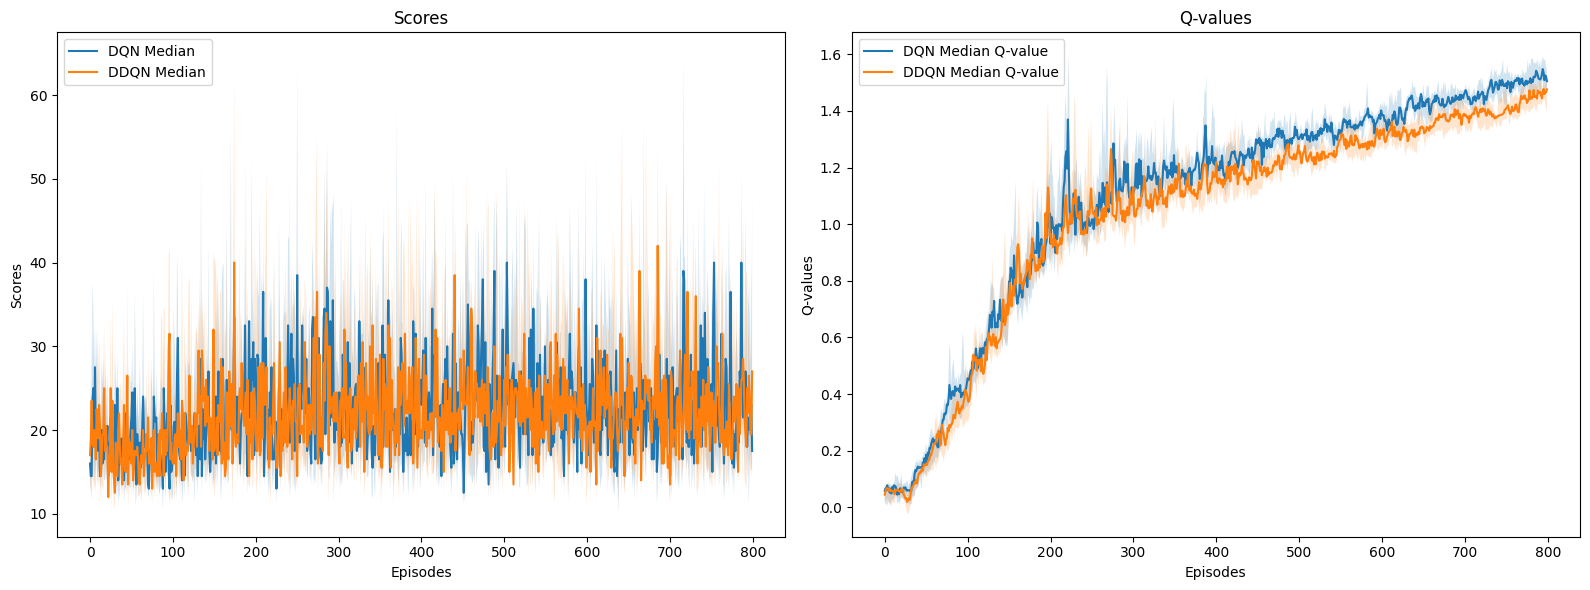

In [ ]:
print("Testing CartPole-v1...")
steps_done = 0
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 5000
# Optimization functions (DQN and DDQN)
BATCH_SIZE = 128
GAMMA = 0.99
num_episodes=200
num_runs=10

#train_and_plot(env_name, num_episodes, num_runs,steps_done,EPS_START,EPS_END,EPS_DECAY,BATCH_SIZE,GAMMA):
train_and_plot(
    env_name="CartPole-v1",
    num_episodes=800,
    num_runs=10,
    steps_done = 0,
    EPS_START=0.9,
    EPS_END=0.05,
    EPS_DECAY=1000,
    BATCH_SIZE=32,
    GAMMA=0.99,
    TAU=0.001
)

Run: 1/10
Run: 2/10
Run: 3/10
Run: 4/10
Run: 5/10
Run: 6/10
Run: 7/10
Run: 8/10
Run: 9/10
Run: 10/10


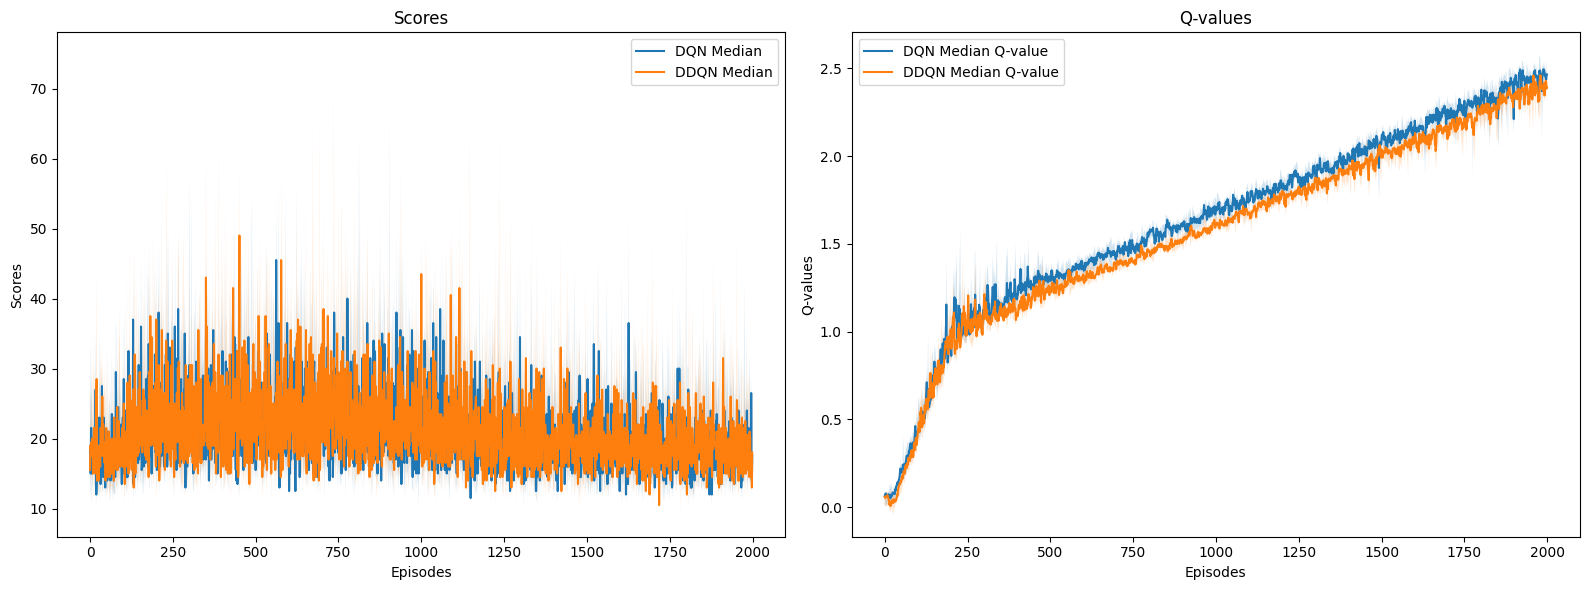

In [ ]:
#train_and_plot(env_name, num_episodes, num_runs,steps_done,EPS_START,EPS_END,EPS_DECAY,BATCH_SIZE,GAMMA):
train_and_plot(
    env_name="CartPole-v1",
    num_episodes=2000,
    num_runs=10,
    steps_done = 0,
    EPS_START=0.9,
    EPS_END=0.05,
    EPS_DECAY=5000,
    BATCH_SIZE=32,
    GAMMA=0.99,
    TAU=0.001
)

Run: 1/10
Run: 2/10
Run: 3/10
Run: 4/10
Run: 5/10
Run: 6/10
Run: 7/10
Run: 8/10
Run: 9/10
Run: 10/10


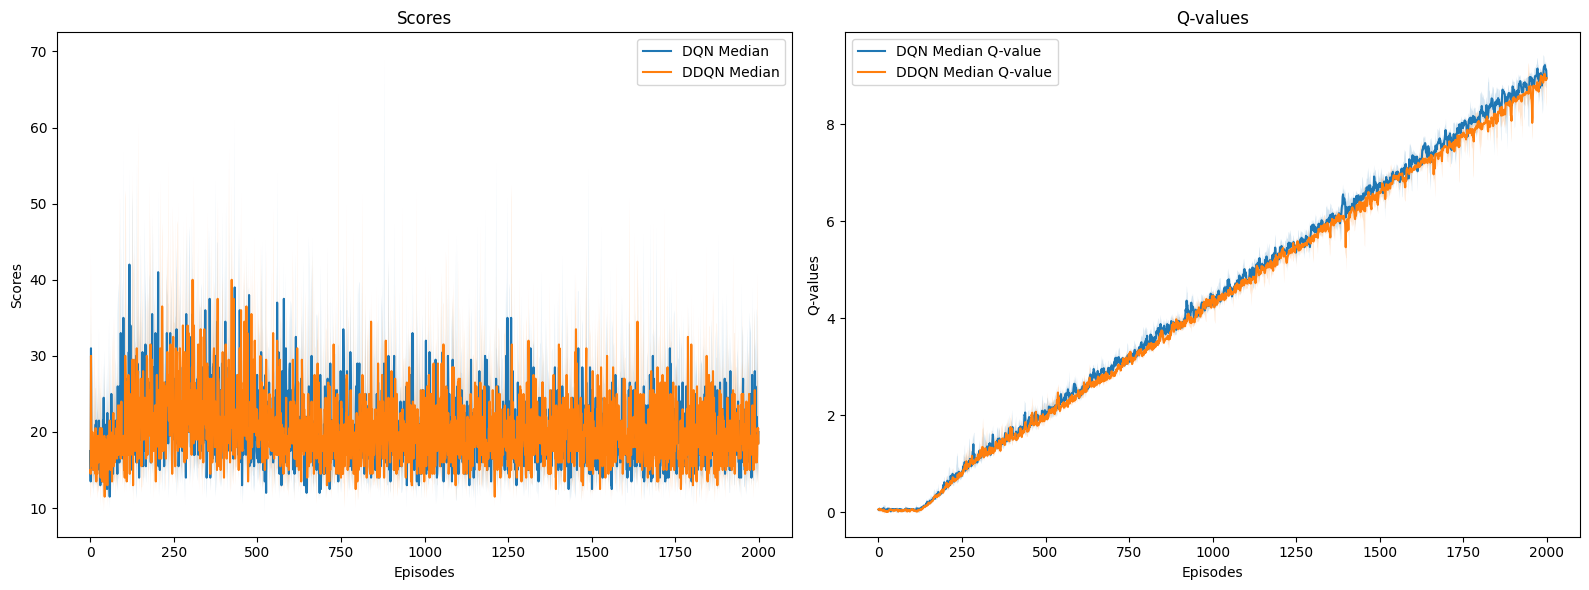

In [ ]:
#train_and_plot(env_name, num_episodes, num_runs,steps_done,EPS_START,EPS_END,EPS_DECAY,BATCH_SIZE,GAMMA):
train_and_plot(
    env_name="CartPole-v1",
    num_episodes=2000,
    num_runs=10,
    steps_done = 0,
    EPS_START=0.9,
    EPS_END=0.05,
    EPS_DECAY=5000,
    BATCH_SIZE=132,
    GAMMA=0.99,
    TAU=0.005
)

In [ ]:
print("Testing Acrobate-v1...")

#train_and_plot(env_name, num_episodes, num_runs,steps_done,EPS_START,EPS_END,EPS_DECAY,BATCH_SIZE,GAMMA):
train_and_plot(
    env_name="Acrobate-v1",
    num_episodes=100,
    num_runs=3,
    steps_done = 0,
    EPS_START=0.9,
    EPS_END=0.05,
    EPS_DECAY=5000,
    BATCH_SIZE=32,
    GAMMA=0.99,
    TAU=0.001
)